In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Dataset_url = 'https://www.kaggle.com/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database'

In [3]:
try:
    db = sqlite3.connect("data/olist.sqlite")
except sqlite3.Error as er:
    print(f"ERROR Reading Data: {er}")

# Database Schema

<div>
    <img src="data/olist_db_schema.png" alt="">
</div>

# Sales Performance


### 1. Total Sales per Seller
>    Analyzes the total revenue generated by each seller based on their associated orders. Helps identify the most successful sellers in terms of sales.

In [4]:
pd.read_sql('''
SELECT 
    s.seller_id,
    s.seller_city,
    s.seller_state,
    SUM(oi.price) AS total_sales
FROM 
    sellers s
JOIN 
    order_items oi ON s.seller_id = oi.seller_id
GROUP BY 
    s.seller_id, s.seller_city, s.seller_state
ORDER BY 
    total_sales DESC;
''', db)

,seller_id,seller_city,seller_state,total_sales
0,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP,229472.63
1,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,222776.05
2,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,200472.92
3,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,194042.03
4,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,187923.89
...,...,...,...,...
3090,34aefe746cd81b7f3b23253ea28bef39,curitiba,PR,8.00
3091,702835e4b785b67a084280efca355756,juiz de fora,MG,7.60
3092,1fa2d3def6adfa70e58c276bb64fe5bb,sao paulo,SP,6.90
3093,77128dec4bec4878c37ab7d6169d6f26,sao paulo,SP,6.50


### 2. Top 10 Selling Products
>   Displays the products sold in the highest quantities. Highlights the most in-demand products among customers.

In [36]:
pd.read_sql('''
SELECT 
    p.product_id,
    p.product_category_name,
    COUNT(oi.order_item_id) AS total_units_sold,
    SUM(oi.price) AS total_revenue
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
GROUP BY 
    p.product_id, p.product_category_name
ORDER BY 
    total_units_sold DESC
LIMIT 10;
''', db)

,product_id,product_category_name,total_units_sold,total_revenue
0,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,527,37608.90
1,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,488,43025.56
2,422879e10f46682990de24d770e7f83d,ferramentas_jardim,484,26577.22
3,389d119b48cf3043d311335e499d9c6b,ferramentas_jardim,392,21440.59
4,368c6c730842d78016ad823897a372db,ferramentas_jardim,388,21056.80
5,53759a2ecddad2bb87a079a1f1519f73,ferramentas_jardim,373,20387.20
6,d1c427060a0f73f6b889a5c7c61f2ac4,informatica_acessorios,343,47214.51
7,53b36df67ebb7c41585e8d54d6772e08,relogios_presentes,323,37683.42
8,154e7e31ebfa092203795c972e5804a6,beleza_saude,281,6325.19
9,3dd2a17168ec895c781a9191c1e95ad7,informatica_acessorios,274,41082.60


### 3. Monthly Sales Revenue
>   Analyzes the total revenue generated each month. Helps identify seasonal or monthly sales trends.

In [36]:
data = pd.read_sql('''
SELECT 
    substr(o.order_purchase_timestamp, 1, 4) AS year,
    substr(o.order_purchase_timestamp, 6, 2) AS month,
    SUM(oi.price) AS total_revenue
FROM 
    orders o
JOIN 
    order_items oi ON o.order_id = oi.order_id
GROUP BY 
    substr(o.order_purchase_timestamp, 1, 4), 
    substr(o.order_purchase_timestamp, 6, 2)
ORDER BY 
    year ASC, month ASC;
''', db)

data

,year,month,total_revenue
0,2016,09,267.36
1,2016,10,49507.66
2,2016,12,10.90
3,2017,01,120312.87
4,2017,02,247303.02
5,2017,03,374344.30
6,2017,04,359927.23
7,2017,05,506071.14
8,2017,06,433038.60
9,2017,07,498031.48


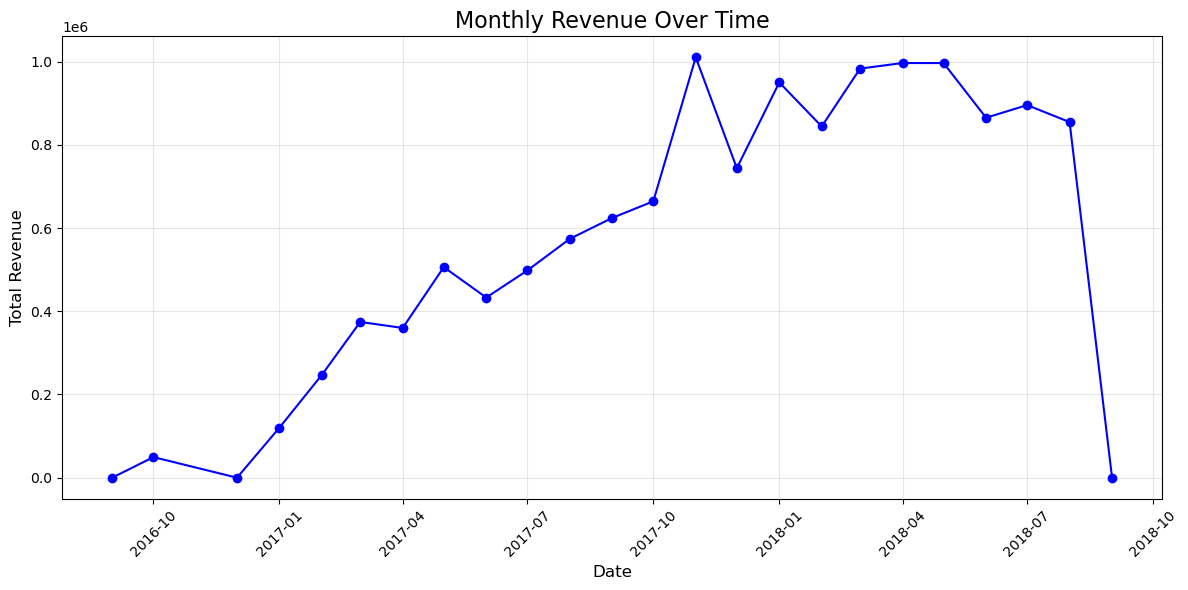

In [37]:
data['date'] = pd.to_datetime(data['year'] + '-' + data['month'] + '-01')

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['total_revenue'], marker='o', linestyle='-', color='b')

plt.title('Monthly Revenue Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### 4. Top 20 Cities by Sales
>   Identifies the cities with the highest sales. Useful for understanding the geographic distribution of product demand.

In [38]:
pd.read_sql('''
SELECT 
    c.customer_city,
    c.customer_state,
    SUM(oi.price) AS total_sales
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
JOIN 
    order_items oi ON o.order_id = oi.order_id
GROUP BY 
    c.customer_city, c.customer_state
ORDER BY 
    total_sales DESC
LIMIT 20;
''', db)

,customer_city,customer_state,total_sales
0,sao paulo,SP,1914924.54
1,rio de janeiro,RJ,992538.86
2,belo horizonte,MG,355611.13
3,brasilia,DF,301920.25
4,curitiba,PR,211738.06
5,porto alegre,RS,190562.08
6,campinas,SP,187844.53
7,salvador,BA,181104.42
8,guarulhos,SP,144268.39
9,niteroi,RJ,117907.12


### 5. Sales by Payment Method
>   Reviews the most commonly used payment methods by customers. Helps optimize available payment options.

In [39]:
pd.read_sql('''
SELECT 
    op.payment_type,
    COUNT(op.order_id) AS total_orders,
    SUM(op.payment_value) AS total_revenue
FROM 
    order_payments op
GROUP BY 
    op.payment_type
ORDER BY 
    total_revenue DESC;
''', db)

,payment_type,total_orders,total_revenue
0,credit_card,76795,12542084.19
1,boleto,19784,2869361.27
2,voucher,5775,379436.87
3,debit_card,1529,217989.79
4,not_defined,3,0.00


### 6. Product Categories Performance
>   Analyzes the revenue of each product category to identify the most profitable ones. Useful for determining which categories need improvement or support.

In [40]:
pd.read_sql('''
SELECT 
    p.product_category_name,
    COUNT(oi.order_item_id) AS total_units_sold,
    SUM(oi.price) AS total_revenue
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
GROUP BY 
    p.product_category_name
ORDER BY 
    total_revenue DESC;
''', db)

,product_category_name,total_units_sold,total_revenue
0,beleza_saude,9670,1258681.34
1,relogios_presentes,5991,1205005.68
2,cama_mesa_banho,11115,1036988.68
3,esporte_lazer,8641,988048.97
4,informatica_acessorios,7827,911954.32
...,...,...,...
69,flores,33,1110.04
70,casa_conforto_2,30,760.27
71,cds_dvds_musicais,14,730.00
72,fashion_roupa_infanto_juvenil,8,569.85


### 7. Confirmed vs. Unconfirmed Orders Analysis
>   Compares confirmed orders with unconfirmed ones. Helps understand the efficiency of sales processes.

In [41]:
pd.read_sql('''
SELECT 
    o.order_status,
    COUNT(o.order_id) AS total_orders,
    SUM(oi.price) AS total_revenue
FROM 
    orders o
JOIN 
    order_items oi ON o.order_id = oi.order_id
GROUP BY 
    o.order_status
ORDER BY 
    total_orders DESC;
''', db)

,order_status,total_orders,total_revenue
0,delivered,110197,13221498.11
1,shipped,1185,150727.44
2,canceled,542,95235.27
3,invoiced,359,61526.37
4,processing,357,60439.22
5,unavailable,7,2007.69
6,approved,3,209.60


### 8. Shipping Cost Analysis per Seller
>   Measures the average shipping cost for each seller. Used to optimize shipping strategies and reduce costs.

In [42]:
pd.read_sql('''
SELECT 
    s.seller_id,
    s.seller_city,
    s.seller_state,
    ROUND(AVG(oi.freight_value), 2) AS avg_shipping_cost
FROM 
    sellers s
JOIN 
    order_items oi ON s.seller_id = oi.seller_id
GROUP BY 
    s.seller_id, s.seller_city, s.seller_state
ORDER BY 
    avg_shipping_cost DESC;
''', db)

,seller_id,seller_city,seller_state,avg_shipping_cost
0,6fa9202c10491e472dffd59a3e82b2a3,sorocaba,SP,308.34
1,c88f62b4c386a59281014d677864d016,arapongas,PR,251.50
2,ee27a8f15b1dded4d213a468ba4eb391,goiania,GO,227.66
3,80ceebb4ee9b31afb6c6a916a574a1e2,londrina,PR,193.21
4,56e361f411e38dcef17cdc2a3d99628b,guarulhos,SP,185.78
...,...,...,...,...
3090,e9e446d01bd10a97a8ffcfc4a3a20cb2,sao paulo,SP,7.39
3091,f0ec6a2adb05c62655a26dd347b8dede,sao paulo,SP,7.39
3092,c97aa4ee7420f937da13b7f9e2228b99,novo hamburgo,RS,6.66
3093,f664f98bfda2eaf266a23ff144e7a872,sao paulo,SP,3.91


### 9. Profit Analysis per Order
>   Calculates the profit generated from each order after deducting costs. Helps identify the most profitable orders.

In [43]:
pd.read_sql('''
SELECT 
    o.order_id,
    SUM(oi.price) AS total_order_value,
    SUM(oi.freight_value) AS total_shipping_cost,
    SUM(oi.price) - SUM(oi.freight_value) AS net_profit
FROM 
    orders o
JOIN 
    order_items oi ON o.order_id = oi.order_id
GROUP BY 
    o.order_id
ORDER BY 
    net_profit DESC;
''', db)

,order_id,total_order_value,total_shipping_cost,net_profit
0,03caa2c082116e1d31e67e9ae3700499,13440.00,224.08,13215.92
1,736e1922ae60d0d6a89247b851902527,7160.00,114.88,7045.12
2,0812eb902a67711a1cb742b3cdaa65ae,6735.00,194.31,6540.69
3,fefacc66af859508bf1a7934eab1e97f,6729.00,193.21,6535.79
4,f5136e38d1a14a4dbd87dff67da82701,6499.00,227.66,6271.34
...,...,...,...,...
98661,af822dacd6f5cff7376413c03a388bb7,61.26,182.76,-121.50
98662,8272b63d03f5f79c56e9e4120aec44ef,31.80,164.37,-132.57
98663,6ef34c0fc67f8eb9f2fee84357c1ae39,74.90,215.43,-140.53
98664,2455cbeb73fd04b170ca2504662f95ce,419.40,1002.29,-582.89


### 10. Number of Orders per City
>   Counts the total number of orders placed by customers in each city. Helps identify cities with the highest demand and potential growth opportunities.

In [44]:
pd.read_sql('''
SELECT 
    c.customer_city AS city,
    COUNT(o.order_id) AS total_orders
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
GROUP BY 
    c.customer_city
ORDER BY 
    total_orders DESC;
''', db)

,city,total_orders
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
...,...,...
4114,acucena,1
4115,acari,1
4116,acajutiba,1
4117,abdon batista,1


# Customer Behavior

### 1. Customer lifetime Value (CLV)

In [7]:
pd.read_sql( '''
SELECT
    c.customer_id,
    SUM(op.payment_value) AS lifetime_value
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
JOIN 
    order_payments op ON o.order_id = op.order_id
GROUP BY 
    c.customer_id
ORDER BY 
    lifetime_value DESC;
''', db)

,customer_id,lifetime_value
0,1617b1357756262bfa56ab541c47bc16,13664.08
1,ec5b2ba62e574342386871631fafd3fc,7274.88
2,c6e2731c5b391845f6800c97401a43a9,6929.31
3,f48d464a0baaea338cb25f816991ab1f,6922.21
4,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66
...,...,...
99435,184e8e8e48937145eb96c721ef1f0747,10.07
99436,a790343ca6f3fee08112d678b43aa7c5,9.59
99437,a73c1f73f5772cf801434bf984b0b1a7,0.00
99438,3532ba38a3fd242259a514ac2b6ae6b6,0.00


### 2. Top 5 Customer Locations by Revenue

In [39]:
data = pd.read_sql(  """
SELECT 
    c.customer_city, 
    c.customer_state, 
    SUM(op.payment_value) AS total_revenue
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
JOIN 
    order_payments op ON o.order_id = op.order_id
GROUP BY 
    c.customer_city, 
    c.customer_state
ORDER BY 
    total_revenue DESC
LIMIT 5;
    """, db)
data

,customer_city,customer_state,total_revenue
0,sao paulo,SP,2203373.09
1,rio de janeiro,RJ,1161927.36
2,belo horizonte,MG,421765.12
3,brasilia,DF,354216.78
4,curitiba,PR,247392.48


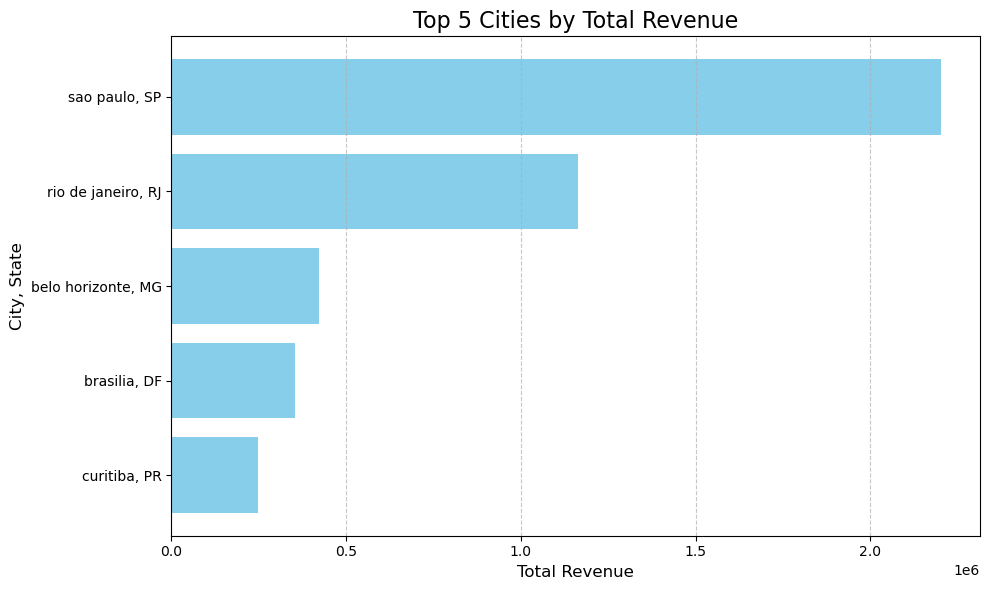

In [40]:
plt.figure(figsize=(10, 6))
plt.barh(data['customer_city'] + ', ' + data['customer_state'], data['total_revenue'], color='skyblue')

plt.title('Top 5 Cities by Total Revenue', fontsize=16)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('City, State', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis() 

plt.tight_layout()
plt.show()

### 3. Customer Churn Rate

In [9]:
pd.read_sql("""
SELECT 
    1 - (COUNT(DISTINCT o.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id)) AS churn_rate
FROM 
    customers c
LEFT JOIN 
    orders o 
ON 
    c.customer_id = o.customer_id 
    AND o.order_status = 'delivered' 
    AND o.order_purchase_timestamp >= DATE('now', '-24 months');
""", db)

,churn_rate
0,1.0


### 4. Customers with the Highest Number of Orders

In [10]:
pd.read_sql( '''
SELECT 
    o.customer_id,
    COUNT(o.order_id) AS order_count
FROM 
    orders o
GROUP BY 
    o.customer_id
ORDER BY 
    order_count DESC
LIMIT 10;
''', db)

,customer_id,order_count
0,ffffe8b65bbe3087b653a978c870db99,1
1,ffffa3172527f765de70084a7e53aae8,1
2,ffff42319e9b2d713724ae527742af25,1
3,fffeda5b6d849fbd39689bb92087f431,1
4,fffecc9f79fd8c764f843e9951b11341,1
5,fffcb937e9dd47a13f05ecb8290f4d3e,1
6,fffc22669ca576ae3f654ea64c8f36be,1
7,fffb97495f78be80e2759335275df2aa,1
8,fffa0238b217e18a8adeeda0669923a3,1
9,fff93c1da78dafaaa304ff032abc6205,1


### 5. Average Order Value by Customer

In [11]:
pd.read_sql( '''
SELECT 
    o.customer_id, 
    AVG(op.payment_value) AS avg_order_value
FROM 
    orders o
JOIN 
    order_payments op ON o.order_id = op.order_id
GROUP BY 
    o.customer_id
ORDER BY 
    avg_order_value DESC
LIMIT 10;
''', db)

,customer_id,avg_order_value
0,1617b1357756262bfa56ab541c47bc16,13664.08
1,ec5b2ba62e574342386871631fafd3fc,7274.88
2,c6e2731c5b391845f6800c97401a43a9,6929.31
3,f48d464a0baaea338cb25f816991ab1f,6922.21
4,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66
5,05455dfa7cd02f13d132aa7a6a9729c6,6081.54
6,df55c14d1476a9a3467f131269c2477f,4950.34
7,e0a2412720e9ea4f26c1ac985f6a7358,4809.44
8,24bbf5fd2f2e1b359ee7de94defc4a15,4764.34
9,3d979689f636322c62418b6346b1c6d2,4681.78


### 6. Most Frequent Order Time of Day

In [12]:
pd.read_sql( '''
SELECT 
    strftime('%H', o.order_purchase_timestamp) AS hour, 
    COUNT(o.order_id) AS order_count
FROM 
    orders o
GROUP BY 
    hour
ORDER BY 
    order_count DESC
LIMIT 5;
''', db)

,hour,order_count
0,16,6675
1,11,6578
2,14,6569
3,13,6518
4,15,6454


### 7. Top Locations for First-Time Orders

In [14]:
pd.read_sql( '''
SELECT 
    c.customer_city, 
    c.customer_state, 
    COUNT(o.order_id) AS first_orders
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
WHERE 
    o.order_id IN (SELECT 
                        MIN(o2.order_id)
                    FROM 
                        orders o2
                    GROUP BY 
                        o2.customer_id)
GROUP BY 
    c.customer_city, 
    c.customer_state
ORDER BY 
    first_orders DESC
LIMIT 5; 
''', db)

,customer_city,customer_state,first_orders
0,sao paulo,SP,15540
1,rio de janeiro,RJ,6882
2,belo horizonte,MG,2773
3,brasilia,DF,2131
4,curitiba,PR,1521


### 8. Top Product Categories Purchased by Customers

In [15]:
pd.read_sql( '''
SELECT 
    pc.product_category_name, 
    COUNT(oi.order_id) AS total_orders
FROM 
    order_items oi
JOIN 
    products p ON oi.product_id = p.product_id
JOIN 
    product_category_name_translation pc ON p.product_category_name = pc.product_category_name
GROUP BY 
    pc.product_category_name
ORDER BY 
    total_orders DESC
LIMIT 5;
''', db)

,product_category_name,total_orders
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827


# Operational Metrics

>   Calculate delivery time for each order to analyze shipping efficiency and identify potential delays.

In [45]:
data = pd.read_sql(  
"""
SELECT  
    o.order_id, 
    oi.freight_value,  
    ROUND(julianday(o.order_delivered_customer_date) - julianday(o.order_purchase_timestamp)) AS delivery_time  
FROM  
    order_items oi  
JOIN  
    orders o ON oi.order_id = o.order_id  
WHERE   
    o.order_delivered_customer_date IS NOT NULL  
    AND o.order_purchase_timestamp IS NOT NULL;  
""", db)

data

,order_id,freight_value,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,8.72,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,22.76,14.0
2,47770eb9100c2d0c44946d9cf07ec65d,19.22,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,27.20,13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8.72,3.0
...,...,...,...
110191,63943bddc261676b46f01ca7ac2f7bd8,20.10,22.0
110192,83c1379a015df1e13d02aae0204711ab,65.02,25.0
110193,11c177c8e97725db2631073c19f07b62,40.59,17.0
110194,11c177c8e97725db2631073c19f07b62,40.59,17.0


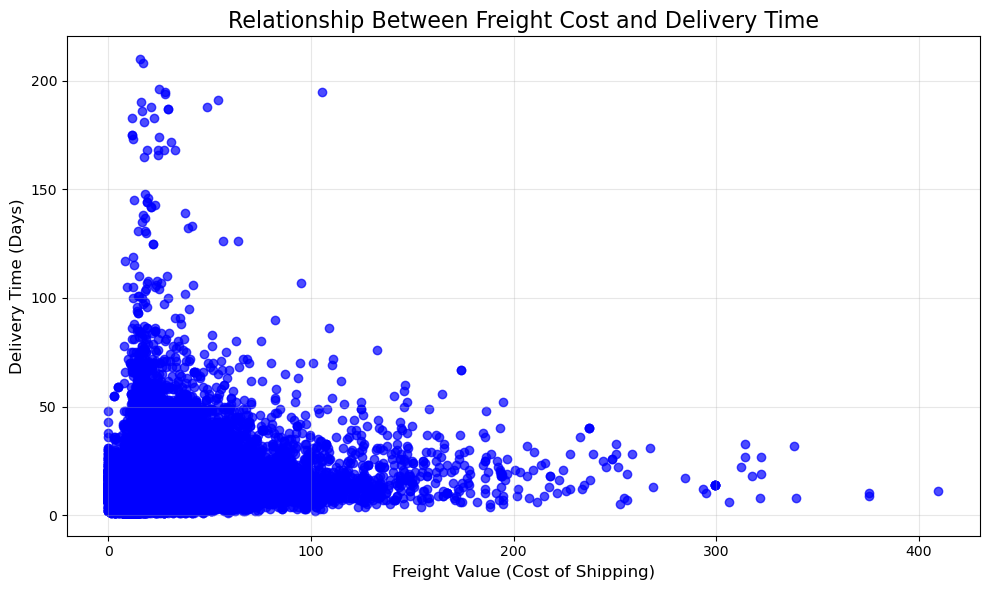

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(data['freight_value'], data['delivery_time'], alpha=0.7, color='blue')

plt.title('Relationship Between Freight Cost and Delivery Time', fontsize=16)
plt.xlabel('Freight Value (Cost of Shipping)', fontsize=12)
plt.ylabel('Delivery Time (Days)', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

>   Calculate the total shipping cost for each product category to identify which categories contribute most to shipping expenses.  

In [10]:
pd.read_sql(
"""
SELECT   
    p.product_category_name,  
    SUM(oi.freight_value) AS total_shipping_cost  
FROM   
    order_items oi  
JOIN   
    products p ON oi.product_id = p.product_id  
GROUP BY   
    p.product_category_name  
ORDER BY   
    total_shipping_cost DESC;
""", db) 

,product_category_name,total_shipping_cost
0,cama_mesa_banho,204693.04
1,beleza_saude,182566.73
2,moveis_decoracao,172749.30
3,esporte_lazer,168607.51
4,informatica_acessorios,147318.08
...,...,...
69,portateis_cozinha_e_preparadores_de_alimentos,309.76
70,cds_dvds_musicais,224.99
71,pc_gamer,133.57
72,fashion_roupa_infanto_juvenil,95.51


>   Identify the top 10 sellers by total revenue and number of delivered orders to evaluate seller performance and profitability.  

In [12]:
pd.read_sql  (
"""
SELECT 
    s.seller_id,
    s.seller_city,
    COUNT(DISTINCT oi.order_id) AS total_orders,
    SUM(oi.price) AS total_revenue
FROM 
    order_items AS oi
JOIN 
    sellers AS s ON oi.seller_id = s.seller_id
JOIN 
    orders AS o ON oi.order_id = o.order_id
WHERE 
    o.order_status = 'delivered'
GROUP BY 
    s.seller_id,
    s.seller_city
ORDER BY 
    total_revenue DESC
LIMIT 10;
""" , db)

,seller_id,seller_city,total_orders,total_revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,1124,226987.93
1,53243585a1d6dc2643021fd1853d8905,lauro de freitas,348,217940.44
2,4a3ca9315b744ce9f8e9374361493884,ibitinga,1772,196882.12
3,fa1c13f2614d7b5c4749cbc52fecda94,sumare,578,190917.14
4,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,973,186570.05
5,7e93a43ef30c4f03f38b393420bc753a,barueri,319,165981.49
6,da8622b14eb17ae2831f4ac5b9dab84a,piracicaba,1311,159816.87
7,7a67c85e85bb2ce8582c35f2203ad736,sao paulo,1145,139658.69
8,1025f0e2d44d7041d6cf58b6550e0bfa,sao paulo,910,138208.56
9,955fee9216a65b617aa5c0531780ce60,sao paulo,1261,131836.71


>   Classify delivered orders as 'Delayed', 'Early', or 'On Time' by comparing the actual delivery date to the estimated delivery date. This helps evaluate delivery efficiency and identify regions with frequent delays.  

In [13]:
pd.read_sql(
"""
SELECT 
    o.order_id,
    c.customer_state,
    (o.order_delivered_customer_date - o.order_estimated_delivery_date) AS delivery_variation,
    CASE 
        WHEN (o.order_delivered_customer_date - o.order_estimated_delivery_date) > 0 THEN 'Delayed'
        WHEN (o.order_delivered_customer_date - o.order_estimated_delivery_date) < 0  THEN 'Early'
        ELSE 'On Time'
    END AS delivery_status
FROM 
    orders AS o
JOIN 
    customers AS c ON o.customer_id = c.customer_id
WHERE 
    o.order_status = 'delivered'
ORDER BY 
    delivery_variation DESC;
""",db)

,order_id,customer_state,delivery_variation,delivery_status
0,9d531c565e28c3e0d756192f84d8731f,RJ,1.0,Delayed
1,8fc207e94fa91a7649c5a5dab690272a,RJ,1.0,Delayed
2,eafef0e6c44f121531569a69a318c3b3,RS,1.0,Delayed
3,8a0b2bc5c7a1c524635f4de8bae9dffe,RS,1.0,Delayed
4,f644267f332fbcb9fe143fbb7478441c,MA,1.0,Delayed
...,...,...,...,...
96473,e69f75a717d64fc5ecdfae42b2e8e086,SP,NaN,On Time
96474,0d3268bad9b086af767785e3f0fc0133,SP,NaN,On Time
96475,2d858f451373b04fb5c984a1cc2defaf,RS,NaN,On Time
96476,ab7c89dc1bf4a1ead9d6ec1ec8968a84,SP,NaN,On Time


>   This query finds products with negative reviews (score ≤ 2), counts the negative reviews, calculates the average score, and shows products with more than 5 negative reviews, ordered by the number of negative reviews.

In [14]:
pd.read_sql (
"""
SELECT 
    p.product_id,
    p.product_category_name,
    COUNT(r.review_id) AS negative_reviews,
    AVG(r.review_score) AS avg_review_score
FROM 
    products AS p
JOIN 
    order_items AS oi ON p.product_id = oi.product_id
JOIN 
    order_reviews AS r ON oi.order_id = r.order_id
WHERE 
    r.review_score <= 2
GROUP BY 
    p.product_id, p.product_category_name
HAVING 
    COUNT(r.review_id) > 5
ORDER BY 
    negative_reviews DESC;
""", db)

,product_id,product_category_name,negative_reviews,avg_review_score
0,422879e10f46682990de24d770e7f83d,ferramentas_jardim,95,1.168421
1,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,80,1.237500
2,53759a2ecddad2bb87a079a1f1519f73,ferramentas_jardim,77,1.155844
3,368c6c730842d78016ad823897a372db,ferramentas_jardim,75,1.133333
4,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,74,1.324324
...,...,...,...,...
445,f8e75ec247fd97a5e1abcaa48e9e971d,construcao_ferramentas_construcao,6,1.000000
446,fb909933914c1f945839287e7c253687,moveis_escritorio,6,1.000000
447,fc5bf9e50dbfb45e7634bd8c045411c5,cool_stuff,6,1.000000
448,fe6a9515d655fa7936b8a7c841039f34,cool_stuff,6,1.000000


>   This query calculates the total number of orders for each city by joining the `orders`, `customers`, and `geolocation` tables. The results are grouped by city and ordered by the total number of orders in descending order.

In [15]:
pd.read_sql(
"""
SELECT 
    g.geolocation_city,
    COUNT(o.order_id) AS total_orders
FROM 
    orders AS o
JOIN 
    customers AS c ON o.customer_id = c.customer_id
JOIN 
    geolocation AS g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY 
    g.geolocation_city
ORDER BY 
    total_orders DESC;
""", db)

,geolocation_city,total_orders
0,rio de janeiro,1913913
1,sao paulo,1164470
2,belo horizonte,737556
3,niteroi,393175
4,curitiba,255731
...,...,...
5807,amanari,1
5808,alvorada do oeste,1
5809,alvorada do gurguéia,1
5810,almirante tamandaré do sul,1


>   This query retrieves the top 10 orders that have more than 5 items. It calculates the total number of items per order and the total value of each order. The results are grouped by `order_id` and ordered by the item count in descending order.

In [16]:
pd.read_sql(
"""
SELECT 
    oi.order_id,
    COUNT(oi.order_item_id) AS item_count,
    SUM(oi.price) AS total_order_value
FROM 
    order_items AS oi
GROUP BY 
    oi.order_id
HAVING 
    COUNT(oi.order_item_id) > 5
ORDER BY 
    item_count DESC
LIMIT 10 ;
""", db)

,order_id,item_count,total_order_value
0,8272b63d03f5f79c56e9e4120aec44ef,21,31.80
1,ab14fdcfbe524636d65ee38360e22ce8,20,1974.00
2,1b15974a0141d54e36626dca3fdc731a,20,2000.00
3,9ef13efd6949e4573a18964dd1bbe7f5,15,765.00
4,428a2f660dc84138d969ccd69a0ab6d5,15,982.35
5,9bdc4d4c71aa1de4606060929dee888c,14,419.86
6,73c8ab38f07dc94389065f7eba4f297a,14,826.00
7,37ee401157a3a0b28c9c6d0ed8c3b24b,13,389.87
8,c05d6a79e55da72ca780ce90364abed9,12,213.84
9,af822dacd6f5cff7376413c03a388bb7,12,61.26


>   This query calculates the total number of orders and total revenue for each product category in each city. It filters for delivered orders and groups the results by customer city and product category, ordering the results by total revenue in descending order.

In [41]:
data = pd.read_sql (
"""
SELECT 
    c.customer_city,
    p.product_category_name,
    COUNT(oi.order_id) AS total_orders,
    SUM(oi.price) AS total_revenue
FROM 
    order_items AS oi
JOIN 
    orders AS o ON oi.order_id = o.order_id
JOIN 
    customers AS c ON o.customer_id = c.customer_id
JOIN 
    products AS p ON oi.product_id = p.product_id
WHERE 
    o.order_status = 'delivered'
GROUP BY 
    c.customer_city, p.product_category_name
ORDER BY 
    total_revenue DESC;
""", db)

data

,customer_city,product_category_name,total_orders,total_revenue
0,sao paulo,beleza_saude,1715,185381.84
1,sao paulo,cama_mesa_banho,1950,168275.99
2,sao paulo,relogios_presentes,826,160142.18
3,sao paulo,esporte_lazer,1355,140847.97
4,sao paulo,informatica_acessorios,1198,139960.84
...,...,...,...,...
25406,tupa,construcao_ferramentas_construcao,1,3.99
25407,caldas novas,fashion_underwear_e_moda_praia,1,3.90
25408,palmeira d'oeste,informatica_acessorios,1,3.90
25409,extrema,musica,1,3.85


# Marketing strategies

### 1. Analyze Initial Interaction Channels
>   Identify the most effective origin channels for attracting potential customers.

In [4]:
pd.read_sql('''
SELECT 
    origin, 
    COUNT(mql_id) AS total_leads,
    COUNT(CASE WHEN l.mql_id IN (SELECT mql_id FROM leads_closed) THEN 1 END) AS converted_leads
FROM 
    leads_qualified l
GROUP BY 
    origin
ORDER BY 
    total_leads DESC;
''', db)

,origin,total_leads,converted_leads
0,organic_search,2296,271
1,paid_search,1586,195
2,social,1350,75
3,unknown,1099,179
4,direct_traffic,499,56
5,email,493,15
6,referral,284,24
7,other,150,4
8,display,118,6
9,other_publicities,65,3


### 2. Top Products Attracting New Customers
>   Determine the most popular products or categories that lead to converting potential customers.

In [5]:
pd.read_sql('''
SELECT 
    p.product_category_name,
    COUNT(DISTINCT lc.mql_id) AS total_converted_leads
FROM 
    leads_closed lc
JOIN 
    order_items oi ON lc.seller_id = oi.seller_id
JOIN 
    products p ON oi.product_id = p.product_id
GROUP BY 
    p.product_category_name
ORDER BY 
    total_converted_leads DESC
LIMIT 10;
''', db)

,product_category_name,total_converted_leads
0,beleza_saude,73
1,utilidades_domesticas,65
2,esporte_lazer,47
3,automotivo,40
4,bebes,34
5,brinquedos,30
6,moveis_decoracao,29
7,papelaria,28
8,informatica_acessorios,28
9,ferramentas_jardim,25


### 3. Seller Performance in Attracting Customers
>   Measure seller performance based on the number of potential customers converted.

In [6]:
pd.read_sql('''
SELECT 
    s.seller_id,
    s.seller_state,
    COUNT(lc.mql_id) AS total_converted_leads
FROM 
    sellers s
LEFT JOIN 
    leads_closed lc ON s.seller_id = lc.seller_id
GROUP BY 
    s.seller_id, s.seller_state
ORDER BY 
    total_converted_leads DESC
LIMIT 10;
''', db)

,seller_id,seller_state,total_converted_leads
0,01266d4c46afa519678d16a8b683d325,PR,1
1,01fd077212124329bac32490e8ef80d9,SP,1
2,02f623a8eb246f3c5f7c2f96462654e6,SP,1
3,03a2a6dcbe45d639c4dc2a0d24769c40,SP,1
4,044668ccd5316b12a7cf0d54a156e3e9,SP,1
5,04843805947f0fc584fc1969b6e50fe7,RS,1
6,05a48cc8859962767935ab9087417fbb,SP,1
7,05e107217c7266362fd44b75b2cd4cc4,SP,1
8,07de60b03d150fb3ea09eab5da5e4c8b,SP,1
9,0873d9f8f36123f8d910f4760e788cfb,SP,1


### 4. Impact of Customer Reviews on Sales
>   Analyze the relationship between product reviews and sales performance.

In [7]:
pd.read_sql('''
SELECT 
    oi.product_id,
    AVG(orv.review_score) AS avg_review_score,
    COUNT(oi.order_id) AS total_sales
FROM 
    order_reviews orv
JOIN 
    orders o ON orv.order_id = o.order_id
JOIN 
    order_items oi ON o.order_id = oi.order_id
GROUP BY 
    oi.product_id
ORDER BY 
    avg_review_score DESC, total_sales DESC
LIMIT 10;
''', db)

,product_id,avg_review_score,total_sales
0,37eb69aca8718e843d897aa7b82f462d,5.0,15
1,03e1c946c0ddfc58724ff262aef08dff,5.0,14
2,8173ca41cdb176462f9ae79821a48404,5.0,14
3,870bcc6c58e03ca658cfdd13db4bbe28,5.0,14
4,8b6ed41158b194711f83b8da92757544,5.0,14
5,2722b7e5f68e776d18fe901638034e54,5.0,13
6,143c616ec3fe0cb065c3805cf9bd812e,5.0,12
7,16ce899c7af0c99f46948734a0d00f0f,5.0,12
8,2ced45a3059cbb128a8b8b6508809746,5.0,11
9,4c8b28305f570899b6ded964ddd234a9,5.0,11


### 5. Identify Customer Patterns by Location
>   Determine the most active regions based on the number of orders and customers.

In [47]:
data = pd.read_sql('''
SELECT 
    g.geolocation_state,
    COUNT(DISTINCT c.customer_id) AS total_customers,
    COUNT(o.order_id) AS total_orders
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
JOIN 
    geolocation g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY 
    g.geolocation_state
ORDER BY 
    total_orders DESC, total_customers DESC
LIMIT 10;
''', db)

data

,geolocation_state,total_customers,total_orders
0,SP,41731,5620430
1,RJ,12839,3015690
2,MG,11624,2878728
3,RS,5473,805370
4,PR,5034,626021
5,SC,3651,538638
6,BA,3371,365875
7,ES,2027,316654
8,GO,2011,133146
9,MT,905,122395


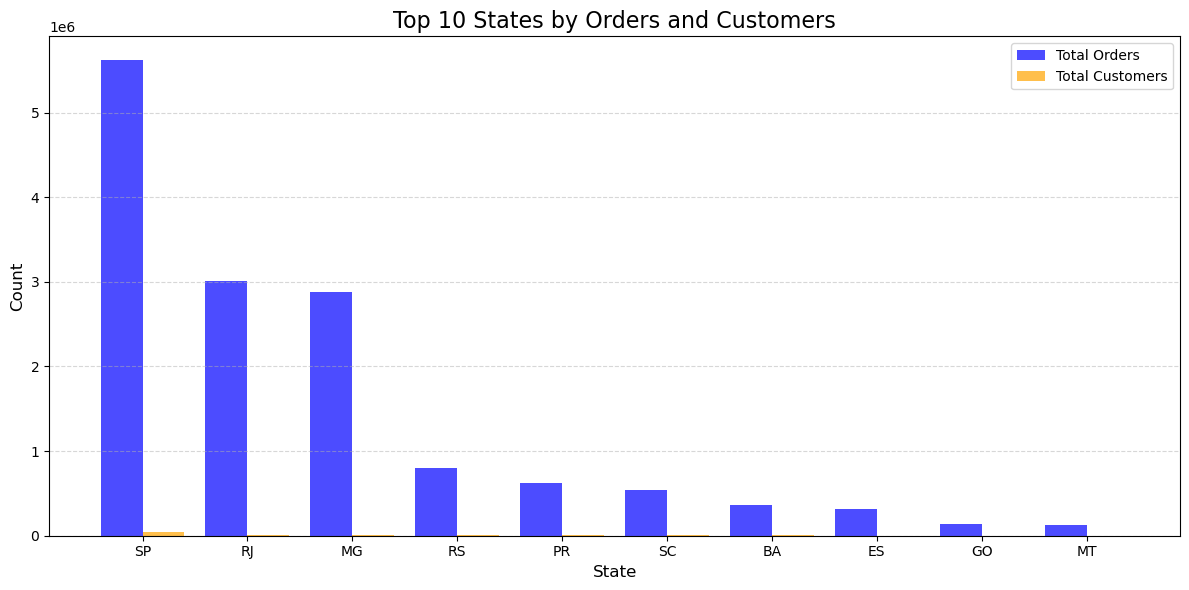

In [48]:
plt.figure(figsize=(12, 6))
bar_width = 0.4

states = data['geolocation_state']
total_orders = data['total_orders']
total_customers = data['total_customers']

x = range(len(states))
plt.bar(x, total_orders, width=bar_width, label='Total Orders', color='blue', alpha=0.7)
plt.bar([p + bar_width for p in x], total_customers, width=bar_width, label='Total Customers', color='orange', alpha=0.7)

plt.title('Top 10 States by Orders and Customers', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([p + bar_width / 2 for p in x], states)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Customer Feedback

### Julianday to get DATEDIFF
>   Is there is a relation between customer review and the time take to deliver the order

In [24]:
query = """
SELECT 
    r.review_score,
    AVG(julianday(o.order_delivered_customer_date) - julianday(o.order_purchase_timestamp)) as delivery_days
FROM 
    orders o 
INNER JOIN 
    order_reviews r ON o.order_id = r.order_id
where 
    order_delivered_customer_date is not null 
    and order_purchase_timestamp is not null
GROUP BY 
    review_score
"""
data = pd.read_sql(query , db)
data

,review_score,delivery_days
0,1,21.311419
1,2,16.660580
2,3,14.261962
3,4,12.312356
4,5,10.688605


<function matplotlib.pyplot.show(close=None, block=None)>

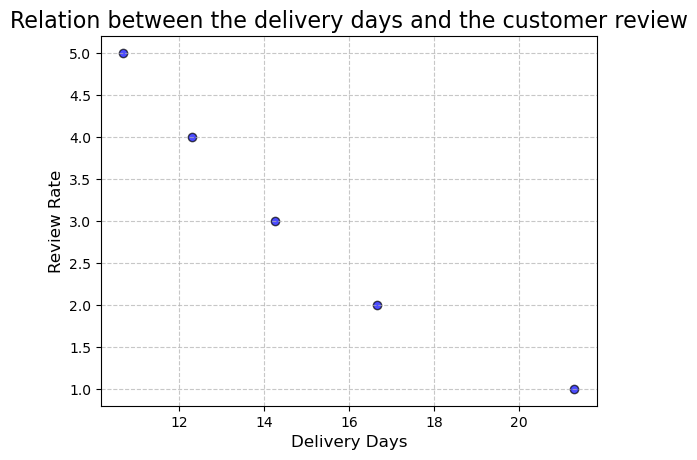

In [25]:
plt.Figure(figsize=(10,6))
plt.scatter(data['delivery_days'],data['review_score'],alpha=0.7,color ='blue' ,edgecolor='k')

plt.title('Relation between the delivery days and the customer review', fontsize = 16)
plt.xlabel('Delivery Days',fontsize = 12)
plt.ylabel('Review Rate',fontsize = 12)

plt.grid(True,linestyle='--',alpha=0.7)
plt.show

>   Display the Gategories with the worest reviews

In [49]:
query = """
SELECT 
    t.product_category_name_english, 
    ROUND(AVG(r.review_score), 1) Review_Score
FROM 
    orders o 
INNER JOIN 
    order_reviews r ON  o.order_id = r.order_id
INNER JOIN 
    order_items oi ON  o.order_id = oi.order_id
INNER JOIN 
    products p ON p.product_id = oi.product_id
INNER JOIN 
    product_category_name_translation t ON p.product_category_name = t.product_category_name
GROUP BY 
    product_category_name_english
ORDER BY 
    Review_Score
LIMIT 10
"""
pd.read_sql(query,db)

,product_category_name_english,Review_Score
0,security_and_services,2.5
1,diapers_and_hygiene,3.3
2,office_furniture,3.5
3,fashion_male_clothing,3.6
4,home_comfort_2,3.6
5,fixed_telephony,3.7
6,audio,3.8
7,construction_tools_safety,3.8
8,fashio_female_clothing,3.8
9,furniture_mattress_and_upholstery,3.8


>   Display the Gategories with the best reviews

In [50]:
query = """
SELECT 
    t.product_category_name_english, 
    ROUND(AVG(r.review_score), 1) Review_Score
FROM 
    orders o
INNER JOIN 
    order_reviews r ON  o.order_id = r.order_id
INNER JOIN 
    order_items oi ON  o.order_id = oi.order_id
INNER JOIN 
    products p ON p.product_id = oi.product_id
INNER JOIN 
    product_category_name_translation t ON p.product_category_name = t.product_category_name
GROUP BY 
    product_category_name_english
ORDER BY 
    Review_Score DESC
LIMIT 10;
"""
pd.read_sql(query,db)

,product_category_name_english,Review_Score
0,cds_dvds_musicals,4.6
1,fashion_childrens_clothes,4.5
2,flowers,4.4
3,costruction_tools_tools,4.4
4,books_technical,4.4
5,books_imported,4.4
6,books_general_interest,4.4
7,small_appliances_home_oven_and_coffee,4.3
8,luggage_accessories,4.3
9,food_drink,4.3


>   Get the states with bad review to imporve the service there

In [31]:
query = """
SELECT 
    c.customer_state, 
    AVG(r.review_score) Review_Score
FROM 
    customers c 
INNER JOIN 
    orders o ON c.customer_id = o.customer_id
INNER JOIN 
    order_reviews r ON o.order_id = r.order_id
GROUP BY 
    customer_state
ORDER BY 
    Review_Score 
LIMIT 10;
"""
pd.read_sql(query,db)

,customer_state,Review_Score
0,RR,3.608696
1,AL,3.751208
2,MA,3.764075
3,SE,3.808023
4,PA,3.849174
5,CE,3.851016
6,BA,3.860888
7,RJ,3.874971
8,PI,3.920570
9,PE,4.011543


>   Order sellers (the best seller who have the highest total sales)

In [32]:
query = """ 
SELECT 
    s.seller_id,
    SUM(oi.price) Total_sales
FROM 
    sellers s 
INNER JOIN 
    order_items oi ON s.seller_id = oi.seller_id
GROUP BY 
    s.seller_id
ORDER BY 
    Total_sales DESC
LIMIT 10;
"""
pd.read_sql(query ,db)

,seller_id,Total_sales
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63
1,53243585a1d6dc2643021fd1853d8905,222776.05
2,4a3ca9315b744ce9f8e9374361493884,200472.92
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03
4,7c67e1448b00f6e969d365cea6b010ab,187923.89
5,7e93a43ef30c4f03f38b393420bc753a,176431.87
6,da8622b14eb17ae2831f4ac5b9dab84a,160236.57
7,7a67c85e85bb2ce8582c35f2203ad736,141745.53
8,1025f0e2d44d7041d6cf58b6550e0bfa,138968.55
9,955fee9216a65b617aa5c0531780ce60,135171.70


>   For each Customer get all Order details for shippment

In [33]:
query = """
SELECT
    c.customer_id, 
    c.customer_city, 
    o.order_id , 
    o.order_status,
    op.payment_value, 
    oi.seller_id, 
    oi.shipping_limit_date,
    p.product_category_name, 
    p.product_weight_g
FROM 
    customers c 
INNER JOIN 
    orders o ON c.customer_id = o.customer_id
INNER JOIN 
    order_payments op ON o.order_id = op.order_id
INNER JOIN 
    order_items oi ON oi.order_id = o.order_id
INNER JOIN 
    products p ON oi.product_id = p.product_id
LIMIT 10
"""
pd.read_sql(query ,db)

,customer_id,customer_city,order_id,order_status,payment_value,seller_id,shipping_limit_date,product_category_name,product_weight_g
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,00e7ee1b050b8499577073aeb2a297a1,delivered,146.87,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,moveis_escritorio,8683.0
1,18955e83d337fd6b2def6b18a428ac77,sao bernardo do campo,29150127e6685892b6eab3eec79f59c7,delivered,335.48,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,utilidades_domesticas,10150.0
2,4e7b3e00288586ebd08712fdd0374a03,sao paulo,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,157.73,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,moveis_escritorio,8267.0
3,b2b6027bc5c5109e529d4dc6358b12c3,mogi das cruzes,951670f92359f4fe4a63112aa7306eba,delivered,173.30,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,moveis_escritorio,12160.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,campinas,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,252.25,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,casa_conforto,5200.0
5,879864dab9bc3047522c92c82e1212b8,jaragua do sul,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,282.21,8f2ce03f928b567e3d56181ae20ae952,2017-09-20 18:25:11,esporte_lazer,4450.0
6,fd826e7cf63160e536e0908c76c3f441,sao paulo,36e694cf4cbc2a4803200c35e84abdc4,delivered,22.77,9f505651f4a6abe901a56cdc21508025,2018-02-23 14:50:37,informatica_acessorios,100.0
7,5e274e7a0c3809e14aba7ad5aae0d407,timoteo,1093c8304c7a003280dd34598194913d,delivered,36.01,2a7dc43cecabf23403078e2188437d1d,2017-11-22 19:55:41,None,250.0
8,5adf08e34b2e993982a47070956c5c65,curitiba,1ebeea841c590e86a14a0d7a48e7d062,delivered,39.10,95e03ca3d4146e4011985981aeb959b9,2018-01-30 12:56:32,brinquedos,350.0
9,4b7139f34592b3a31687243a302fa75b,belo horizonte,7433cbcc783205509d66a5260da5b574,delivered,122.47,0241d4d5d36f10f80c644447315af0bd,2018-01-12 11:35:27,moveis_decoracao,2500.0
